### E25 KorQuAD Task

- 학습목표 
    - Transformer Encoder로 이루어진 BERT의 모델구조를 이해한다. 
    - Pretrained embedding 접근 방식에 대해 이해한다. 
    - Pretrained BERT를 활용할 수 있다.

In [72]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

#### 1. 데이터 로드 및 전처리

In [73]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:
            print(f'{indent}- {key} : [{len(value)}]')
            print_json_tree(value[0], indent + " ")
        else:
            print(f'{indent}- {key} : {value}')

In [74]:
data_dir = os.getenv('HOME') + '/aiffel/bert_qna/data'
model_dir = os.getenv('HOME') + '/aiffel/bert_qna/models'

train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version : KorQuAD_v1.0_train
- data : [1420]
 - paragraphs : [3]
  - qas : [8]
   - answers : [1]
    - text : 교향곡
    - answer_start : 54
   - id : 6566495-0-0
   - question : 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
  - context : 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
 - title : 파우스트_서곡


In [75]:
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version : KorQuAD_v1.0_dev
- data : [140]
 - paragraphs : [2]
  - qas : [7]
   - answers : [1]
    - text : 1989년 2월 15일
    - answer_start : 0
   - id : 6548850-0-0
   - question : 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
  - context : 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
 - title : 임종석


In [76]:
print(json.dumps(train_json["data"][0], indent=2, ensure_ascii=False))

{
  "paragraphs": [
    {
      "qas": [
        {
          "answers": [
            {
              "text": "교향곡",
              "answer_start": 54
            }
          ],
          "id": "6566495-0-0",
          "question": "바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?"
        },
        {
          "answers": [
            {
              "text": "1악장",
              "answer_start": 421
            }
          ],
          "id": "6566495-0-1",
          "question": "바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?"
        },
        {
          "answers": [
            {
              "text": "베토벤의 교향곡 9번",
              "answer_start": 194
            }
          ],
          "id": "6566495-0-2",
          "question": "바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?"
        },
        {
          "answers": [
            {
              "text": "파우스트",
              "answer_start": 15
            }
          ],
          "id": "6566518-0-0",
          "question": "1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?"
        },
        {
    

##### 1.1 띄어쓰기 단위 정보관리

In [77]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [78]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True
    
    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else: 
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False
        char_to_word.append(len(word_tokens) - 1)
        
    return word_tokens, char_to_word

##### 1.2 Tokenize by Vocab

In [79]:
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

##### 1.3 Improve Span

In [80]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1
assert context[answer_start:answer_end + 1] == answer_text 

context, question, answer_text, answer_start, context[answer_start], context[answer_end], context[answer_start:answer_end + 1]

('1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 '교향곡',
 54,
 '교',
 '곡',
 '교향곡')

In [81]:
word_tokens, char_to_word = _tokenize_whitespace(context)
word_tokens[:20], char_to_word[:20]

(['1839년',
  '바그너는',
  '괴테의',
  '파우스트을',
  '처음',
  '읽고',
  '그',
  '내용에',
  '마음이',
  '끌려',
  '이를',
  '소재로',
  '해서',
  '하나의',
  '교향곡을',
  '쓰려는',
  '뜻을',
  '갖는다.',
  '이',
  '시기'],
 [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [82]:
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁1839', '년']
2 ['▁바그너', '는']
4 ['▁괴테', '의']
6 ['▁', '파우스트', '을']
9 ['▁처음']
10 ['▁읽고']
11 ['▁그']
12 ['▁내용에']
13 ['▁마음이']
14 ['▁끌려']
15 ['▁이를']
16 ['▁소재로']
17 ['▁해서']
18 ['▁하나의']
19 ['▁교향곡', '을']
21 ['▁쓰', '려는']
23 ['▁뜻을']
24 ['▁갖는다', '.']
26 ['▁이']
27 ['▁시기']


In [83]:
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, '교향곡', ['교향곡을'])

In [84]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['▁교향곡', '을'])

In [85]:
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁교향곡'

In [86]:
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

X >> (19, 20) ▁교향곡 을
O >> (19, 19) ▁교향곡
X >> (20, 20) 을


In [87]:
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

##### 1.4 데이터셋 분리

In [88]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)
                
                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1
                    
                    assert answer_text == context[answer_start:answer_end + 1]
                    
                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]
                    
                    word_answer = " ".join(context_words[word_start : word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer
                    
                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)
                    
                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1
                        
                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)
                    
                    data = {"qa_id": qa_id, "title":title, "question":vocab.encode_as_pieces(question), "context":context_tokens, "answer":char_answer, "token_start":token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [89]:
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

In [90]:
def print_file(file_name, count=10):
    
    with open(file_name) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())
            
print_file(f"{data_dir}/korquad_train.json")

{"qa_id": "6566495-0-0", "title": "파우스트_서곡", "question": ["▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "를", "▁읽고", "▁무엇을", "▁쓰고", "자", "▁", "했", "는", "가", "?"], "context": ["▁1839", "년", "▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "을", "▁처음", "▁읽고", "▁그", "▁내용에", "▁마음이", "▁끌려", "▁이를", "▁소재로", "▁해서", "▁하나의", "▁교향곡", "을", "▁쓰", "려는", "▁뜻을", "▁갖는다", ".", "▁이", "▁시기", "▁바그너", "는", "▁1838", "년에", "▁빛", "▁독", "촉", "으로", "▁산", "전", "수", "전을", "▁다", "▁", "걲", "은", "▁상황이", "라", "▁좌절", "과", "▁실망", "에", "▁가득", "했으며", "▁메", "피스", "토", "펠", "레스", "를", "▁만나는", "▁", "파우스트", "의", "▁심", "경에", "▁공감", "했다고", "▁한다", ".", "▁또한", "▁파리에서", "▁아브", "네", "크의", "▁지휘", "로", "▁파리", "▁음악원", "▁관현악단", "이", "▁연주하는", "▁베토벤", "의", "▁교향곡", "▁9", "번을", "▁듣고", "▁깊은", "▁감", "명을", "▁받았는데", ",", "▁이것이", "▁이듬해", "▁1", "월에", "▁", "파우스트", "의", "▁서", "곡으로", "▁쓰여진", "▁이", "▁작품에", "▁조금", "이라도", "▁영향을", "▁끼", "쳤", "으리라", "는", "▁것은", "▁의심", "할", "▁여지가", "▁없다", ".", "▁여기", "의", "▁라", "단", "조", "▁조성", "의", "▁경우에도", "▁그의", "▁전기", "에", "▁적혀", "▁있는", 

##### 1.5 데이터 분석 : Question

In [91]:
questions = []
contexts = []
token_starts = []
with open(f"{data_dir}/korquad_train.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data['question'])
        contexts.append(data['context'])
        token_starts.append(data['token_start'])
        
        if i < 10:
            print(data['token_start'], data['question'], data['context'])

19 ['▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '를', '▁읽고', '▁무엇을', '▁쓰고', '자', '▁', '했', '는', '가', '?'] ['▁1839', '년', '▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '을', '▁처음', '▁읽고', '▁그', '▁내용에', '▁마음이', '▁끌려', '▁이를', '▁소재로', '▁해서', '▁하나의', '▁교향곡', '을', '▁쓰', '려는', '▁뜻을', '▁갖는다', '.', '▁이', '▁시기', '▁바그너', '는', '▁1838', '년에', '▁빛', '▁독', '촉', '으로', '▁산', '전', '수', '전을', '▁다', '▁', '걲', '은', '▁상황이', '라', '▁좌절', '과', '▁실망', '에', '▁가득', '했으며', '▁메', '피스', '토', '펠', '레스', '를', '▁만나는', '▁', '파우스트', '의', '▁심', '경에', '▁공감', '했다고', '▁한다', '.', '▁또한', '▁파리에서', '▁아브', '네', '크의', '▁지휘', '로', '▁파리', '▁음악원', '▁관현악단', '이', '▁연주하는', '▁베토벤', '의', '▁교향곡', '▁9', '번을', '▁듣고', '▁깊은', '▁감', '명을', '▁받았는데', ',', '▁이것이', '▁이듬해', '▁1', '월에', '▁', '파우스트', '의', '▁서', '곡으로', '▁쓰여진', '▁이', '▁작품에', '▁조금', '이라도', '▁영향을', '▁끼', '쳤', '으리라', '는', '▁것은', '▁의심', '할', '▁여지가', '▁없다', '.', '▁여기', '의', '▁라', '단', '조', '▁조성', '의', '▁경우에도', '▁그의', '▁전기', '에', '▁적혀', '▁있는', '▁것처럼', '▁단순한', '▁정신적', '▁피로', '나', '▁실', '의', '가', '▁반영', '된', '▁

165 ['▁바그너', '가', '▁처음', '▁교향곡', '▁작곡', '을', '▁한', '▁장소', '는', '?'] ['▁1839', '년', '▁바그너', '는', '▁괴테', '의', '▁', '파우스트', '을', '▁처음', '▁읽고', '▁그', '▁내용에', '▁마음이', '▁끌려', '▁이를', '▁소재로', '▁해서', '▁하나의', '▁교향곡', '을', '▁쓰', '려는', '▁뜻을', '▁갖는다', '.', '▁이', '▁시기', '▁바그너', '는', '▁1838', '년에', '▁빛', '▁독', '촉', '으로', '▁산', '전', '수', '전을', '▁다', '▁', '걲', '은', '▁상황이', '라', '▁좌절', '과', '▁실망', '에', '▁가득', '했으며', '▁메', '피스', '토', '펠', '레스', '를', '▁만나는', '▁', '파우스트', '의', '▁심', '경에', '▁공감', '했다고', '▁한다', '.', '▁또한', '▁파리에서', '▁아브', '네', '크의', '▁지휘', '로', '▁파리', '▁음악원', '▁관현악단', '이', '▁연주하는', '▁베토벤', '의', '▁교향곡', '▁9', '번을', '▁듣고', '▁깊은', '▁감', '명을', '▁받았는데', ',', '▁이것이', '▁이듬해', '▁1', '월에', '▁', '파우스트', '의', '▁서', '곡으로', '▁쓰여진', '▁이', '▁작품에', '▁조금', '이라도', '▁영향을', '▁끼', '쳤', '으리라', '는', '▁것은', '▁의심', '할', '▁여지가', '▁없다', '.', '▁여기', '의', '▁라', '단', '조', '▁조성', '의', '▁경우에도', '▁그의', '▁전기', '에', '▁적혀', '▁있는', '▁것처럼', '▁단순한', '▁정신적', '▁피로', '나', '▁실', '의', '가', '▁반영', '된', '▁것이', '▁아니라', '▁베토벤', '의', '▁합창'

In [92]:
train_question_counts = [len(question) for question in questions]
train_question_counts[:10]

[16, 14, 16, 12, 16, 13, 10, 13, 16, 18]

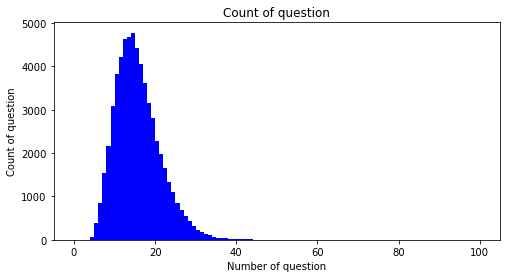

In [93]:
plt.figure(figsize=(8, 4))
plt.hist(train_question_counts, bins=100, range=[0, 100], facecolor='b', label='train')
plt.title("Count of question")
plt.xlabel("Number of question")
plt.ylabel("Count of question")
plt.show()

In [94]:
print(f"question 길이 최대: {np.max(train_question_counts):4d}")
print(f"question 길이 최소: {np.min(train_question_counts):4d}")
print(f"question 길이 평균: {np.mean(train_question_counts):7.2f}")
print(f"question 길이 표준편차: {np.std(train_question_counts):7.2f}")

percentile25 = np.percentile(train_question_counts, 25)
percentile50 = np.percentile(train_question_counts, 50)
percentile75 = np.percentile(train_question_counts, 75)
percentileQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileQR * 1.5

print(f"question 25/100분위: {percentile25:7.2f}")
print(f"question 50/100분위: {percentile50:7.2f}")
print(f"question 75/100분위: {percentile75:7.2f}")
print(f"question IQR: {percentileQR:7.2f}")
print(f"question MAX/100분위: {percentileMAX:7.2f}")

question 길이 최대:   58
question 길이 최소:    3
question 길이 평균:   15.25
question 길이 표준편차:    5.50
question 25/100분위:   11.00
question 50/100분위:   14.00
question 75/100분위:   18.00
question IQR:    7.00
question MAX/100분위:   28.50


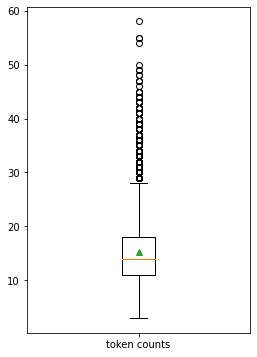

In [95]:
plt.figure(figsize=(4, 6))

plt.boxplot(train_question_counts, labels=["token counts"], showmeans=True)
plt.show()

##### 1.6 데이터 분석 : Context

In [96]:
train_context_counts = [len(context) for context in contexts]
train_context_counts[:10]

[278, 278, 278, 278, 278, 278, 278, 278, 209, 209]

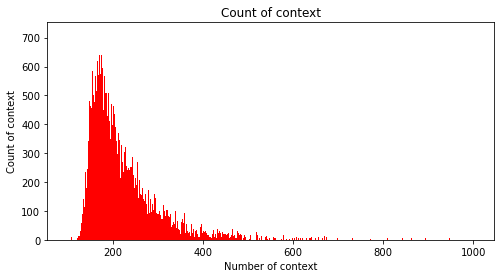

In [97]:
plt.figure(figsize=(8, 4))

plt.hist(train_context_counts, bins=900, range=[100, 1000], facecolor='r', label='train')
plt.title('Count of context')
plt.xlabel('Number of context')
plt.ylabel('Count of context')
plt.show()

In [98]:
print(f"context 길이 최대: {np.max(train_context_counts):4d}")
print(f"context 길이 최소: {np.min(train_context_counts):4d}")
print(f"context 길이 평균: {np.mean(train_context_counts):7.2f}")
print(f"context 길이 표준편차: {np.std(train_context_counts):7.2f}")

percentile25 = np.percentile(train_context_counts, 25)
percentile50 = np.percentile(train_context_counts, 50)
percentile75 = np.percentile(train_context_counts, 75)
percentileQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileQR * 1.5

print(f"context 25/100분위: {percentile25:7.2f}")
print(f"context 50/100분위: {percentile50:7.2f}")
print(f"context 75/100분위: {percentile75:7.2f}")
print(f"context IQR: {percentileQR:7.2f}")
print(f"context MAX/100분위: {percentileMAX:7.2f}")

context 길이 최대: 4816
context 길이 최소:  108
context 길이 평균:  222.84
context 길이 표준편차:   97.68
context 25/100분위:  169.00
context 50/100분위:  199.00
context 75/100분위:  248.00
context IQR:   79.00
context MAX/100분위:  366.50


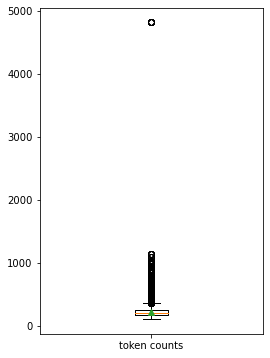

In [99]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_context_counts, labels=['token counts'], showmeans=True)
plt.show()

##### 1.7 데이터 분석 : Answer

In [100]:
train_answer_starts = token_starts
train_answer_starts[:10]

[19, 168, 80, 6, 143, 0, 165, 216, 164, 7]

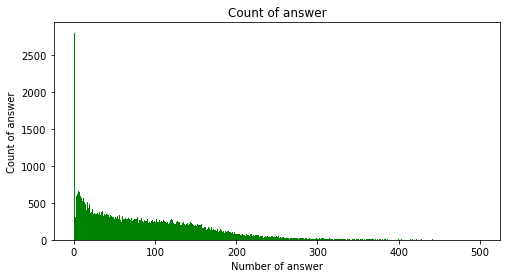

In [101]:
plt.figure(figsize=(8, 4))
plt.hist(train_answer_starts, bins=500, range=[0, 500], facecolor='g', label='train')
plt.title('Count of answer')
plt.xlabel('Number of answer')
plt.ylabel('Count of answer')
plt.show()

In [102]:
print(f"answer 위치 최대: {np.max(train_answer_starts):4d}")
print(f"answer 위치 최소 {np.min(train_answer_starts):4d}")
print(f"answer 위치 평균: {np.mean(train_answer_starts):7.2f}")
print(f"answer 위치 표준편차: {np.std(train_answer_starts):7.2f}")

percentile25 = np.percentile(train_answer_starts, 25)
percentile50 = np.percentile(train_answer_starts, 50)
percentile75 = np.percentile(train_answer_starts, 75)
percentileQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileQR * 1.5

print(f"answer 25/100분위: {percentile25:7.2f}")
print(f"answer 50/100분위: {percentile50:7.2f}")
print(f"answer 75/100분위: {percentile75:7.2f}")
print(f"answer IQR: {percentileQR:7.2f}")
print(f"answer MAX/100분위: {percentileMAX:7.2f}")

answer 위치 최대: 1124
answer 위치 최소    0
answer 위치 평균:   89.01
answer 위치 표준편차:   78.21
answer 25/100분위:   25.00
answer 50/100분위:   74.00
answer 75/100분위:  134.00
answer IQR:  109.00
answer MAX/100분위:  297.50


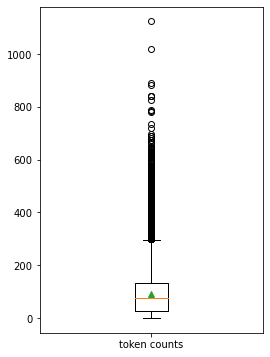

In [103]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

##### 1.8 데이터 분석:Word Cloud

In [104]:
documents = []

for data in tqdm(train_json["data"]):
    title = data["title"]
    documents.append(title)
    for paragraph in data["paragraphs"]:
        context = paragraph["context"]
        documents.append(context)
        
        for qa in paragraph["qas"]:
            assert len(qa["answers"]) == 1
            question = qa["question"]
            documents.append(question)
            
documents[:10]

['파우스트_서곡',
 '1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.',
 '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?',
 '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?',
 '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?',
 '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?',
 '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?',
 '바그너가 파우스트를 처음으로 읽은 년도는?',
 '바그너가 처음 교향곡 작곡을 한 장소는?',
 '바그너의 1악장의 초연은 어디서 연주되었는가?']

In [105]:
" ".join(documents[:10])

'파우스트_서곡 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다. 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가? 바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가? 바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가? 1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은? 파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은? 바그너가 파우스트를 처음으로 읽은 년도는? 바그너가 처음 교향곡 작곡을 한 장소는? 바그너의 1악장의 초연은 어디서 연주되었는가?'

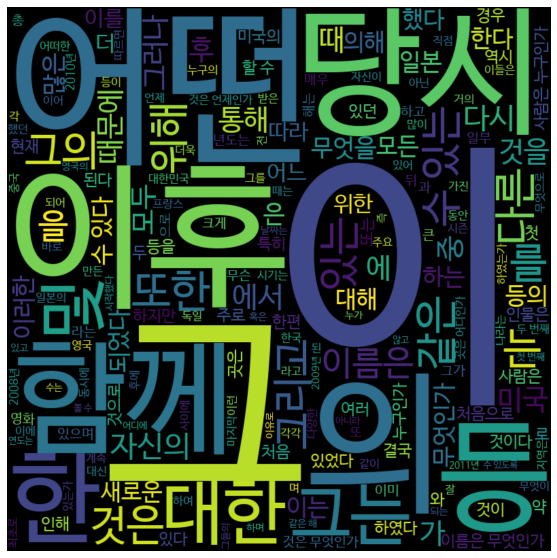

In [106]:
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(" ".join(documents))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

##### 1.9 데이터 로드

In [107]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [108]:
class Config(dict):
    
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    
args = Config({
    'max_seq_length' : 384,
    'max_query_length': 64,
})

args

{'max_seq_length': 384, 'max_query_length': 64}

In [109]:
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []
    
    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3
            
            if token_end >= context_len:
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3
            
            tokens = ['[CSL]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f"n_discard: {n_discard}")
    
    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [110]:
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

dev_inputs, dev_labels = load_data(args, dev_json)

print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]



n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)



n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    1, 15798,    10, ...,     0,     0,     0],
         [    1, 15798,    10, ...,     0,     0,     0],
         [    1, 15798,    19, ...,     0,     0,     0],
         ...,
         [    1, 21666,    19, ...,     0,     0,     0],
         [    1,   964, 16865, ...,     0,     0,     0],
         [    1,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

In [111]:
train_inputs[0][0]

array([    1, 15798,    10, 28935,     9,    11, 29566,    20, 14604,
       20424,  3904,    70,    11,  4648,    10,    19,  1910,     4,
       22070,    15, 15798,    10, 28935,     9,    11, 29566,    16,
         626, 14604,    38, 14028, 11773, 13829,   384,  8376,  3021,
        1239,  6874,    16,  1687,  5958,  2694,  5061,     7,    30,
        1613, 15798,    10, 28065,    75,  4415,  1816,  4978,    27,
         347,   145,   107,  2703,   263,    11,     1,    18,  5853,
          99,  9677,    24, 11969,    13,  7595,   437,  1019,  5907,
         257,  3794,  1972,    20, 11278,    11, 29566,     9,   612,
       12631, 13214,  1732,    76,     7,   110,  8802, 17581,   354,
        9648,  2060,    21,  1682, 22110, 18164,    17, 21076, 14980,
           9,  6874,    81, 11325,  4239,  3597,  1010,  1035, 17670,
           8,  2447,  1306,    35,   443,    11, 29566,     9,   315,
       12729, 14457,    30,  7938,  3742, 10766,   634,  9971, 17590,
       19424,    10,

In [112]:
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [113]:
train_labels[0][0], train_labels[1][0]

(37, 37)

#### 2. 모델 구현 및 학습


In [114]:
def get_pad_mask(tokens, i_pad=0):
    
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask

def get_ahead_mask(tokens, i_pad=0):
    
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

@tf.function(experimental_relax_shapes=True)
def gelu(x):
    
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))

def kernel_initializer(stddev=0.02):
    
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)

def bias_initializer():
    
    return tf.zeros_initializer

class Config(dict):
    
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    
    @classmethod
    def load(cls, file):
        
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [115]:
class SharedEmbedding(tf.keras.layers.Layer):
    
    def __init__(self, config, name="weight_shared_embedding"):
        
        super().__init__(name=name)
        
        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
        
    def build(self, input_shape):
        
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer(),
            )
            
    def call(self, inputs, mode="embedding"):
        
        if mode == "embedding":
            return self._embedding(inputs)
        elif mode == "linear":
            return self._linear(inputs)
        else:
            raise ValueError(f"mode {mode} is not valid.")
            
    def _embedding(self, inputs):
        
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed
    
    def _linear(self, inputs):
        
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])
        return outputs

In [116]:
class PositionalEmbedding(tf.keras.layers.Layer):
    
    def __init__(self, config, name="position_embedding"):
        
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())
        
    def call(self, inputs):
        
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [117]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    
    def __init__(self, name="scale_dot_product_attention"):
        
        super().__init__(name=name)
        
    def call(self, Q, K, V, attn_mask):
        
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        
        return attn_out

In [118]:
class MultiHeadAttention(tf.keras.layers.Layer):
    
    def __init__(self, config, name="multi_head_attention"):
        
        super().__init__(name=name)
        
        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head
        
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        
        self.attention = ScaleDotProductAttention(name="self_attention")
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        
    def call(self, Q, K, V, attn_mask):
        
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)
        
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])
        attn_out = self.W_O(attn_out)
        
        return attn_out          

In [119]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    
    def __init__(self, config, name="feed_forward"):
        
        super().__init__(name=name)
        
        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        
    def call(self, inputs):
        
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [120]:
class EncoderLayer(tf.keras.layers.Layer):
    
    def __init__(self, config, name="encoder_layer"):
        
        super().__init__(name=name)
        
        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.dropout = tf.keras.layers.Dropout(config.dropout)
        
    def call(self, enc_embed, self_mask):
        
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))
        
        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))
        
        return enc_out

In [121]:
class BERT(tf.keras.layers.Layer):
    
    def __init__(self, config, name="bert"):
        
        super().__init__(name=name)
        
        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]
        
        self.dropout = tf.keras.layers.Dropout(config.dropout)
        
    def call(self, enc_tokens, segments):
        
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)
        
        enc_embed = self.get_embedding(enc_tokens, segments)
        
        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)
            
        logits_cls = enc_out[:, 0]
        logits_lm = enc_out
        
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [122]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name="BERT4KorQuAD")
        
        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
        
    def call(self, enc_tokens, segments):
        
        logits_cls, logits_lm = self.bert(enc_tokens, segments)
        
        hidden = self.dense(logits_lm)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)
        
        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)
        
        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)
        
        return start_outputs, end_outputs

In [123]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

In [124]:
bert_batch_size = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

##### 2.1 Non pretrained BERT

In [125]:
model = BERT4KorQuAD(config)

In [126]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')
    
    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)
            
            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss
            
            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 ==9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()
    
    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [127]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')
    
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        
        start_outputs, end_outputs = model(enc_tokens, segments)
        
        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)
        
        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)
        
        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        
    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [128]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = 0
patience = 0

bert_start_loss_ls = []
bert_end_loss_ls = []
bert_start_acc_ls = []
bert_end_acc_ls = []
eval_bert_start_loss_ls = []
eval_bert_end_loss_ls = []
eval_bert_start_acc_ls = []
eval_bert_end_acc_ls = []



for epoch in range(20):
    start_loss, end_loss, start_acc, end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    eval_start_loss, eval_end_loss, eval_start_acc, eval_end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc:{start_acc:0.4f}, {end_acc:0.4f}')
    
    bert_start_loss_ls.append(start_loss)
    bert_end_loss_ls.append(end_loss)
    bert_start_acc_ls.append(start_acc)
    bert_end_acc_ls.append(end_acc)
    
    eval_bert_start_loss_ls.append(eval_start_loss)
    eval_bert_end_loss_ls.append(eval_end_loss)
    eval_bert_start_acc_ls.append(eval_start_acc)
    eval_bert_end_acc_ls.append(eval_end_acc)
    
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0 
        best_acc = acc
        model.save_weights(os.path.join(data_dir, 'korquad_bert_none_pretrain.hdf5'))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break


eval 0 >> loss: 4.0692, 4.5867, acc:0.0797, 0.0623
save best model



eval 1 >> loss: 3.3700, 3.9058, acc:0.1510, 0.1254
save best model



eval 2 >> loss: 3.0965, 3.5730, acc:0.1948, 0.1699
save best model



eval 3 >> loss: 2.9186, 3.3136, acc:0.2252, 0.2079
save best model



eval 4 >> loss: 2.7616, 3.0729, acc:0.2546, 0.2464
save best model



eval 5 >> loss: 2.5585, 2.7568, acc:0.2965, 0.3016
save best model



eval 6 >> loss: 2.3217, 2.4171, acc:0.3512, 0.3717
save best model



eval 7 >> loss: 1.9935, 1.9745, acc:0.4330, 0.4708
save best model



eval 8 >> loss: 1.6454, 1.5651, acc:0.5223, 0.5659
save best model



eval 9 >> loss: 1.3742, 1.2940, acc:0.5921, 0.6365
save best model



eval 10 >> loss: 1.0669, 0.9985, acc:0.6776, 0.7132
save best model



eval 11 >> loss: 0.8559, 0.8124, acc:0.7400, 0.7635
save best model



eval 12 >> loss: 0.7114, 0.6957, acc:0.7845, 0.7960
save best model



eval 13 >> loss: 0.6420, 0.6395, acc:0.8070, 0.8120
save best model



eval 14 >> loss: 0.5639, 0.5803, acc:0.8305, 0.8317
save best model



eval 15 >> loss: 0.4976, 0.5086, acc:0.8484, 0.8514
save best model



eval 16 >> loss: 0.4627, 0.4742, acc:0.8621, 0.8616
save best model



eval 17 >> loss: 0.4075, 0.4622, acc:0.8765, 0.8621
save best model



eval 18 >> loss: 0.4185, 0.4980, acc:0.8755, 0.8524



eval 19 >> loss: 0.3844, 0.4363, acc:0.8837, 0.8717
save best model


##### 2.2 Pretrained BERT

In [129]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    model.load_weights(os.path.join(model_dir, 'bert_pretrain_32000.hdf5'), by_name=True)
    
    model.summary()
else:
    print("No Pretrained Model")

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  10662400  
_________________________________________________________________
dense_75 (Dense)             multiple                  514       
Total params: 10,662,914
Trainable params: 10,662,914
Non-trainable params: 0
_________________________________________________________________


In [130]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = 0
patience = 0

prebert_start_loss_ls = []
prebert_end_loss_ls = []
prebert_start_acc_ls = []
prebert_end_acc_ls = []
eval_prebert_start_loss_ls = []
eval_prebert_end_loss_ls = []
eval_prebert_start_acc_ls = []
eval_prebert_end_acc_ls = []

for epoch in range(20):
    start_loss, end_loss, start_acc, end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    eval_start_loss, eval_end_loss, eval_start_acc, eval_end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc:{start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    
    prebert_start_loss_ls.append(start_loss)
    prebert_end_loss_ls.append(end_loss)
    prebert_start_acc_ls.append(start_acc)
    prebert_end_acc_ls.append(end_acc)
    
    eval_prebert_start_loss_ls.append(eval_start_loss)
    eval_prebert_end_loss_ls.append(eval_end_loss)
    eval_prebert_start_acc_ls.append(eval_start_acc)
    eval_prebert_end_acc_ls.append(eval_end_acc)
    
    if best_acc < acc:
        patience = 0 
        best_acc = acc
        model.save_weights(os.path.join(data_dir, 'korquad_bert_none_pretrain.hdf5'))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break


eval 0 >> loss: 3.9302, 4.4491, acc:0.1021, 0.0809
save best model



eval 1 >> loss: 3.2584, 3.8089, acc:0.1672, 0.1426
save best model



eval 2 >> loss: 3.0054, 3.4708, acc:0.2082, 0.1872
save best model



eval 3 >> loss: 2.8090, 3.1816, acc:0.2411, 0.2289
save best model



eval 4 >> loss: 2.6050, 2.8706, acc:0.2823, 0.2836
save best model



eval 5 >> loss: 2.3230, 2.4838, acc:0.3430, 0.3615
save best model



eval 6 >> loss: 1.9884, 2.0572, acc:0.4239, 0.4549
save best model



eval 7 >> loss: 1.6197, 1.6275, acc:0.5190, 0.5573
save best model



eval 8 >> loss: 1.3266, 1.3202, acc:0.5996, 0.6314
save best model



eval 9 >> loss: 1.0302, 1.0639, acc:0.6863, 0.6982
save best model



eval 10 >> loss: 0.8053, 0.8553, acc:0.7518, 0.7539
save best model



eval 11 >> loss: 0.6517, 0.6995, acc:0.8011, 0.7966
save best model



eval 12 >> loss: 0.5199, 0.5827, acc:0.8449, 0.8287
save best model



eval 13 >> loss: 0.4513, 0.5081, acc:0.8661, 0.8510
save best model



eval 14 >> loss: 0.3855, 0.4579, acc:0.8857, 0.8668
save best model



eval 15 >> loss: 0.3978, 0.4727, acc:0.8809, 0.8619



eval 16 >> loss: 0.3042, 0.3692, acc:0.9105, 0.8928
save best model



eval 17 >> loss: 0.2936, 0.3613, acc:0.9152, 0.8975
save best model



eval 18 >> loss: 0.2500, 0.3089, acc:0.9263, 0.9111
save best model



eval 19 >> loss: 0.2297, 0.2812, acc:0.9324, 0.9195
save best model


#### 3. 결과

In [131]:
def do_predict(model, question, context):
    
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CSL]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    tokens_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)
    
    y_start, y_end = model(np.array([tokens_ids]), np.array([segments]))
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]
    
    return vocab.decode_pieces(answer_tokens)

In [132]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i, answer, "/", answer_predict)
        if 100 < i:
            break

3 학생회관 건물 계단 / 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청
5 임종석 / 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은
16 1924년 12월 2일 / 1924년 12월 2일 ~ 2010년 2월 20일
17 국무장관 / 국무장관을 지냈으며, 리처드 닉슨과 제럴드 포드 대통령 밑에서 백악관 비서실장을 지냈다. 또한 그는 미국 군대에서 2번째로 높은 직위인 미국 육군 부참모 총장과 나토 및 미국 군대의 유럽연합군 최고사령관이었다. 한국 전쟁 시절 더글러스 맥아더 유엔군 사령관의 참모로 직접 참전하였으며, 로널드 레이건 정부 출범당시 초대 국무장관직을 맡아 1980년대 대한민국과 미국의 관계를 조율해 왔다. 저서로 회고록 《경고:현실주의
25 정통 제병 연합부대 / 217번째 사관으로서 졸업하였다. 22세의 소위로 헤이그는 처음에 캔자스 주 포트라일리에서 정통 제병 연합부대로, 그러고나서 켄터키 주 포트녹스에 있는 기갑 훈련소로 갔다. 그후에 그는 제1 기병 사단으로 선임되고 그러고나서 일본에서 점령군의 임무와 기력이 없는 훈련을
27 1979년 / 1973년부터 1974

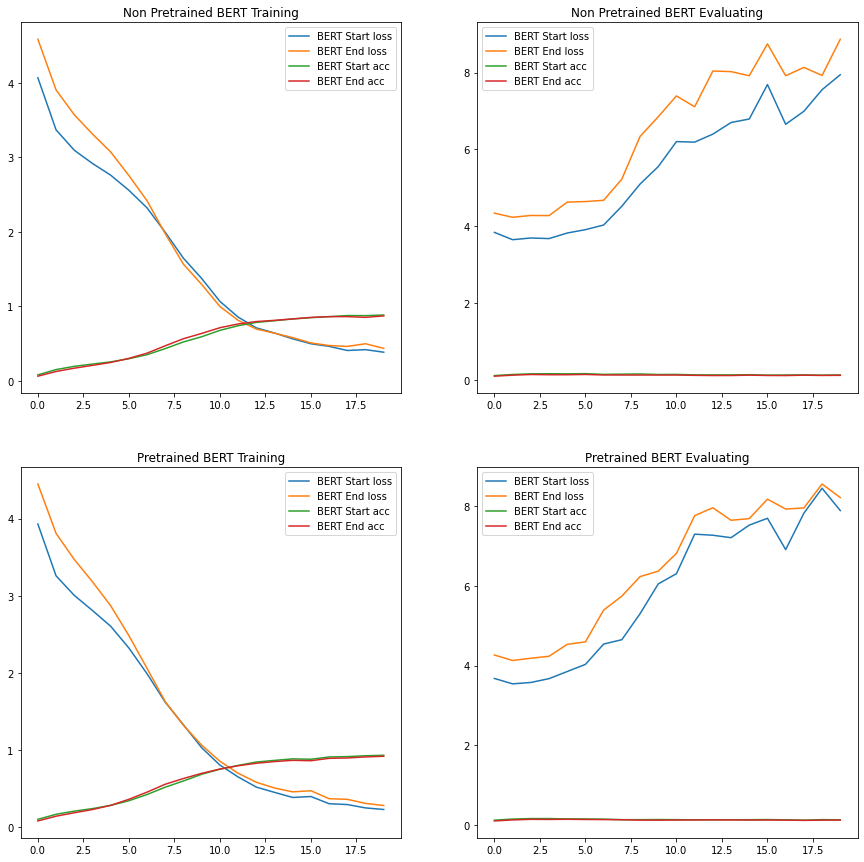

In [133]:
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(range(len(bert_start_loss_ls)), bert_start_loss_ls, label="BERT Start loss")
plt.plot(range(len(bert_end_loss_ls)), bert_end_loss_ls, label="BERT End loss")
plt.plot(range(len(bert_start_acc_ls)), bert_start_acc_ls, label="BERT Start acc")
plt.plot(range(len(bert_end_acc_ls)), bert_end_acc_ls, label="BERT End acc")
plt.legend(loc='upper right')
plt.title('Non Pretrained BERT Training')

plt.subplot(2, 2, 2)
plt.plot(range(len(eval_bert_start_loss_ls)), eval_bert_start_loss_ls, label="BERT Start loss")
plt.plot(range(len(eval_bert_end_loss_ls)), eval_bert_end_loss_ls, label="BERT End loss")
plt.plot(range(len(eval_bert_start_acc_ls)), eval_bert_start_acc_ls, label="BERT Start acc")
plt.plot(range(len(eval_bert_end_acc_ls)), eval_bert_end_acc_ls, label="BERT End acc")
plt.legend(loc='upper left')
plt.title('Non Pretrained BERT Evaluating')

plt.subplot(2, 2, 3)
plt.plot(range(len(prebert_start_loss_ls)), prebert_start_loss_ls, label="BERT Start loss")
plt.plot(range(len(prebert_end_loss_ls)), prebert_end_loss_ls, label="BERT End loss")
plt.plot(range(len(prebert_start_acc_ls)), prebert_start_acc_ls, label="BERT Start acc")
plt.plot(range(len(prebert_end_acc_ls)), prebert_end_acc_ls, label="BERT End acc")
plt.legend(loc='upper right')
plt.title('Pretrained BERT Training')

plt.subplot(2, 2, 4)
plt.plot(range(len(eval_prebert_start_loss_ls)), eval_prebert_start_loss_ls, label="BERT Start loss")
plt.plot(range(len(eval_prebert_end_loss_ls)), eval_prebert_end_loss_ls, label="BERT End loss")
plt.plot(range(len(eval_prebert_start_acc_ls)), eval_prebert_start_acc_ls, label="BERT Start acc")
plt.plot(range(len(eval_prebert_end_acc_ls)), eval_prebert_end_acc_ls, label="BERT End acc")
plt.legend(loc='upper left')
plt.title('Pretrained BERT Evaluating')
plt.show()

#### 4. 고찰 

- Pretrained Model의 학습이 더 빠르게 진행되는 것을 확인할 수 있었고 학습한 모델을 사용하여 예측을 한 결과를 보면 상당히 정확도가 높은 것을 알 수 있었다. 모델을 학습하기 위해서는 상당히 많은 양의 데이터와 비용이 필요한데 Pretrained BERT를 활용한다면 다양한 자연어 처리 Task를 해결할 수 있을것으로 보인다. 
